In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import statsmodels.api as sm
from matplotlib.ticker import FormatStrFormatter
from sklearn.linear_model import LinearRegression
import geopandas
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import mse
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import math
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
import warnings


# EDA and Cleaning

In [21]:
file = pd.read_csv("National_Interagency_Fire_Occurrence_Sixth_Edition_1992-2020_(Feature_Layer).csv")
dataframe = pd.DataFrame(file)
new_data = pd.DataFrame(file)
print(new_data["DISCOVERY_DATE"].unique())
print(new_data["OWNER_DESCR"].unique())
new_data.drop(["LOCAL_FIRE_REPORT_ID", "LOCAL_INCIDENT_ID", "FIRE_CODE", "ICS_209_PLUS_INCIDENT_JOIN_ID", "ICS_209_PLUS_COMPLEX_JOIN_ID", "MTBS_ID", "MTBS_FIRE_NAME", "COMPLEX_NAME", "DISCOVERY_TIME", "CONT_TIME", "NWCG_CAUSE_AGE_CATEGORY", "FIPS_CODE", "FIPS_NAME", "OBJECTID", "FOD_ID", "FPA_ID", "SOURCE_SYSTEM_TYPE", "SOURCE_SYSTEM", "NWCG_REPORTING_AGENCY", "NWCG_REPORTING_UNIT_ID", "NWCG_REPORTING_UNIT_NAME", "SOURCE_REPORTING_UNIT", "SOURCE_REPORTING_UNIT_NAME", "COUNTY"], axis=1, inplace=True)
new_data.dropna(subset=["CONT_DATE"], inplace=True)
print(new_data["NWCG_CAUSE_CLASSIFICATION"].value_counts())
new_data.drop(new_data[new_data['NWCG_CAUSE_CLASSIFICATION'] == 'Missing data/not specified/undetermined' ].index, inplace=True)
new_data.drop(new_data[new_data["NWCG_GENERAL_CAUSE"] == 'Missing data/not specified/undetermined' ].index, inplace=True)
new_data["DISCOVERY_DATE"] = pd.to_datetime(new_data["DISCOVERY_DATE"], errors='coerce',utc=True)
new_data["CONT_DATE"] = pd.to_datetime(new_data["CONT_DATE"], errors='coerce',utc=True)
new_data["FIRE_YEAR"] = pd.to_datetime(new_data["FIRE_YEAR"], format="%Y")
new_data["FIRE_YEAR"] = new_data["FIRE_YEAR"].dt.year
new_data= new_data[new_data["FIRE_YEAR"] != 2004]
firedf = new_data[(new_data["FIRE_SIZE"] > 5000) ]
firedf.info()

/var/folders/y3/ph_dk0xn09n503mvdjfq9r1h0000gn/T/ipykernel_62457/2896480430.py:1: DtypeWarning: Columns (10,12,13,14,15,16,17,18,19,20,27,28,37,39) have mixed types. Specify dtype option on import or set low_memory=False.
  file = pd.read_csv("National_Interagency_Fire_Occurrence_Sixth_Edition_1992-2020_(Feature_Layer).csv")


['2005/02/02 00:00:00+00' '2004/05/12 00:00:00+00'
 '2004/05/31 00:00:00+00' ... '2020/12/20 00:00:00+00'
 '2020/11/26 00:00:00+00' '2020/01/26 00:00:00+00']
['USFS' 'STATE OR PRIVATE' 'MISSING/NOT SPECIFIED' 'OTHER FEDERAL' 'BIA'
 'FWS' 'TRIBAL' 'PRIVATE' 'STATE' 'BLM' 'NPS' 'BOR' 'FOREIGN'
 'UNDEFINED FEDERAL' 'MUNICIPAL/LOCAL' 'COUNTY' 'Private']
NWCG_CAUSE_CLASSIFICATION
Human                                      1058420
Natural                                     278210
Missing data/not specified/undetermined      72123
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 3386 entries, 188 to 2303564
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   X                          3386 non-null   float64            
 1   Y                          3386 non-null   float64            
 2   FIRE_NAME                  3372 non-null   object          

# Fire Statistics: Size and Counts

### Scatter Plot w/ Lowess Line: Fire Counts over 28 Years

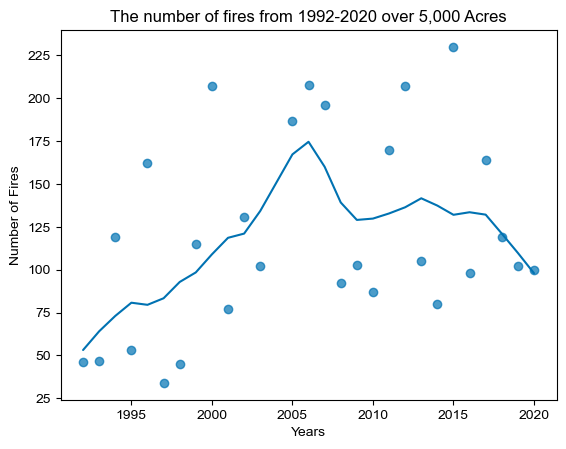

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     2.989
Date:                Thu, 24 Apr 2025   Prob (F-statistic):             0.0957
Time:                        09:44:01   Log-Likelihood:                -150.83
No. Observations:                  28   AIC:                             305.7
Df Residuals:                      26   BIC:                             308.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4106.5193   2445.242     -1.679      0.1

In [3]:
fire_counts = firedf['FIRE_YEAR'].value_counts().sort_index()
x = fire_counts.index
y = fire_counts.values
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.scatter(x, y, alpha=0.7, color="#0072B2")
X = sm.add_constant(x)
model = sm.OLS(y,X).fit()
sns.set_style("darkgrid")
lowess = sm.nonparametric.lowess
smoothed_data = lowess(y, x, frac=0.3)
plt.plot(smoothed_data[:, 0], smoothed_data[:, 1],  label='LOWESS Smoothing', color="#0072B2")
plt.xlabel("Years")
plt.ylabel("Number of Fires")
plt.title("The number of fires from 1992-2020 over 5,000 Acres")
plt.show()
print(model.summary())



### Scatter Plot w/ Regression Line: Mean Fire Size over the years

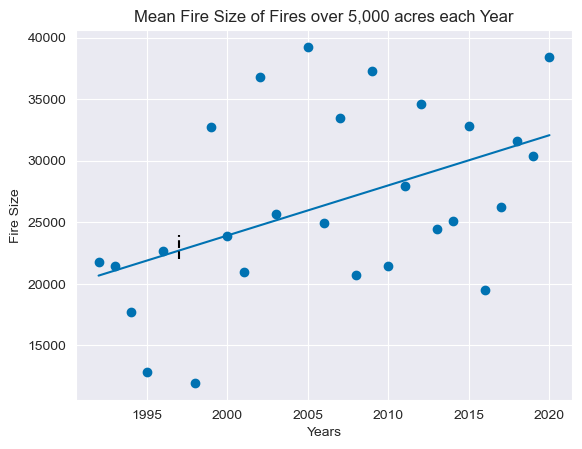

                            OLS Regression Results                            
Dep. Variable:              FIRE_SIZE   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     7.083
Date:                Thu, 24 Apr 2025   Prob (F-statistic):             0.0134
Time:                        09:44:01   Log-Likelihood:                -275.31
No. Observations:                  27   AIC:                             554.6
Df Residuals:                      25   BIC:                             557.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.907e+05   3.07e+05     -2.575      0.0

In [4]:
mean_fire_per_year = firedf.groupby('FIRE_YEAR')['FIRE_SIZE'].mean().reset_index()
#mean_fire_per_year = mean_fire_per_year[mean_fire_per_year["FIRE_YEAR"] != 2004]
mean_fire_per_year = mean_fire_per_year[mean_fire_per_year["FIRE_YEAR"] != 1997]
x = mean_fire_per_year[["FIRE_YEAR"]]
y = np.log10(mean_fire_per_year["FIRE_SIZE"])
y = mean_fire_per_year["FIRE_SIZE"]
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.scatter(x,y, color="#0072B2")
X = sm.add_constant(x)
model = sm.OLS(y,X).fit()
sns.lineplot(x=mean_fire_per_year["FIRE_YEAR"], y=model.fittedvalues, color="#0072B2")
plt.xlabel("Years")
plt.ylabel("Fire Size")
plt.title("Mean Fire Size of Fires over 5,000 acres each Year")
sns.set_style("darkgrid")
plt.vlines(x=1997, ymin=22000, ymax=24000, linestyles="dashed", color="black")
plt.show()
print(model.summary())

# Fire Statistics: Time

### Box Plot: Fire Season Length

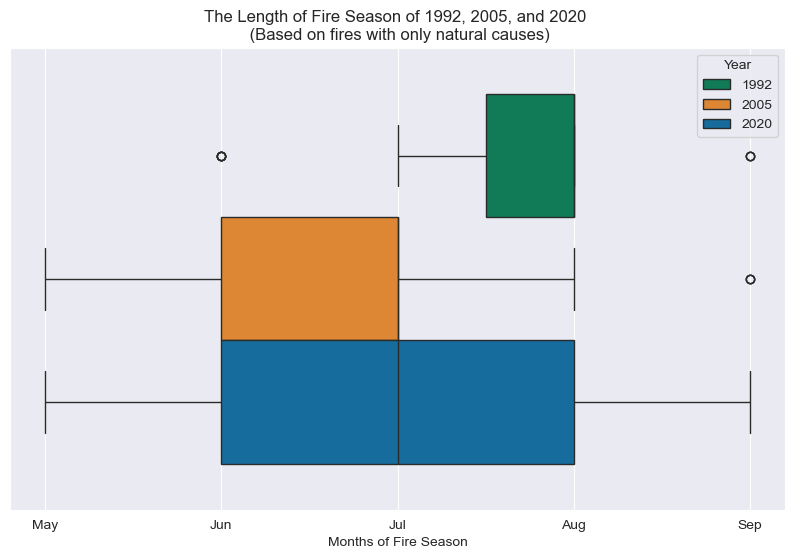

In [5]:
#USED AI TO GET THE X-TICKS WORKING
months = firedf.copy()
months = months[months["NWCG_CAUSE_CLASSIFICATION"] == "Natural"]
months.loc[:, 'Month'] = months['DISCOVERY_DATE'].dt.month
df_years  =months[months["FIRE_YEAR"].isin([1992,2005,2020])].copy()
month_order = {5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep'}
colors = ["#008c5c","#f98517", "#0072B2"]
df_years['Month'] = df_years['Month'].map(month_order) 
df_years['Month'] = pd.Categorical(df_years['Month'], categories=month_order.values(), ordered=True)
plt.figure(figsize=(10, 6))
sns.boxplot(df_years, x='Month', hue='FIRE_YEAR', palette=colors)
plt.xlabel("Months of Fire Season")
plt.title("The Length of Fire Season of 1992, 2005, and 2020 \n (Based on fires with only natural causes)")
plt.legend(title="Year")
plt.show()

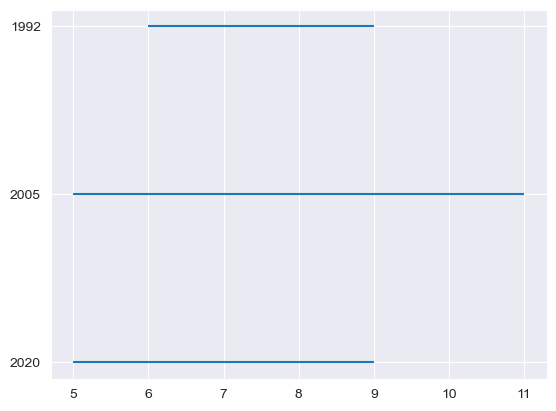

In [6]:
months = firedf.copy()
months = months[months["NWCG_CAUSE_CLASSIFICATION"] == "Natural"]
months.loc[:, 'Month'] = months['DISCOVERY_DATE'].dt.month
df_years  =months[months["FIRE_YEAR"].isin([1992,2005,2020])].copy()
month_order = {5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep'}
ninetwo = df_years[df_years["FIRE_YEAR"] == 1992]
twofive = df_years[df_years["FIRE_YEAR"] == 2005]
twotwo = df_years[df_years["FIRE_YEAR"] == 2020]
plt.hlines(y="2020", xmin=min(twotwo["Month"]), xmax=max(twotwo["Month"]))
plt.hlines(y="2005", xmin=min(twofive["Month"]), xmax=max(twofive["Month"]))
plt.hlines(y= "1992", xmin=min(ninetwo["Month"]), xmax=max(ninetwo["Month"]))

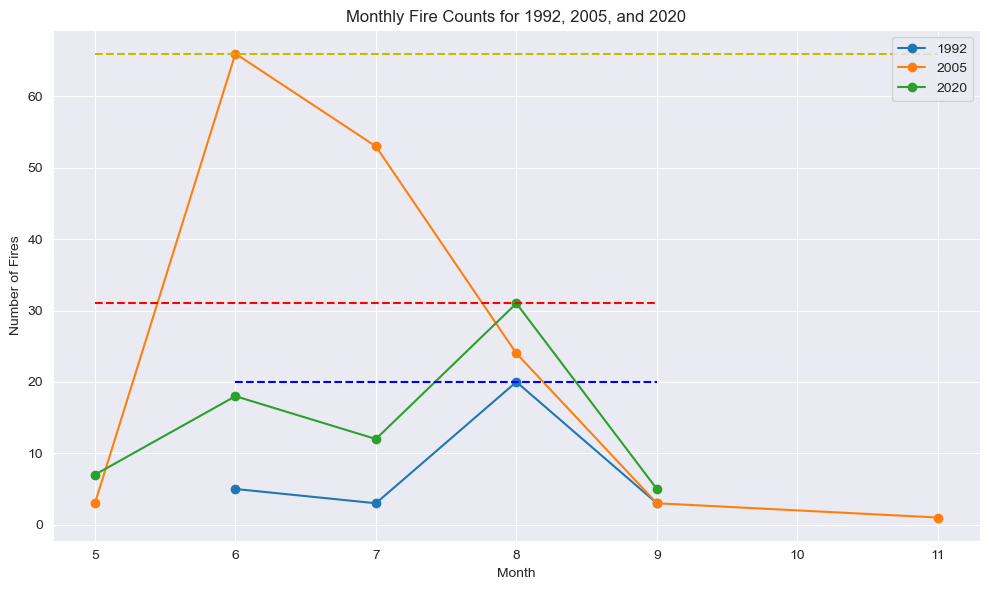

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Example structure: your DataFrame should have at least these columns
# df = pd.read_csv('fires.csv')
# df['date'] = pd.to_datetime(df['date'])

# Filter for the years 1992, 2005, and 2020
years_to_compare = [1992, 2005,2020]

months = firedf.copy()
months = months[months["NWCG_CAUSE_CLASSIFICATION"] == "Natural"]
months.loc[:, 'Month'] = months['DISCOVERY_DATE'].dt.month
df_years  =months[months["FIRE_YEAR"].isin([1992,2005,2020])].copy()
ninetwo = df_years[df_years["FIRE_YEAR"] == 1992]
twofive = df_years[df_years["FIRE_YEAR"] == 2005]
twotwo = df_years[df_years["FIRE_YEAR"] == 2020]
# Plotting
plt.figure(figsize=(10, 6))
for year in years_to_compare:
    monthly_counts = df_years[df_years['FIRE_YEAR'] == year]['Month'].value_counts().sort_index()
    plt.plot(monthly_counts.index, monthly_counts.values, marker='o', label=f'{year}')

# Customize plot
plt.title('Monthly Fire Counts for 1992, 2005, and 2020')
plt.xlabel('Month')
plt.ylabel('Number of Fires')
plt.xticks(range(3, 13))
plt.hlines(y= max(ninetwo["Month"].value_counts()), xmin=min(ninetwo["Month"]), xmax=max(ninetwo["Month"]), color="b", linestyles="dashed")
plt.hlines(y=max(twofive["Month"].value_counts()), xmin=min(twofive["Month"]), xmax=max(twofive["Month"]), color="y", linestyles="dashed")
plt.hlines(y=max(twotwo["Month"].value_counts()), xmin=min(twotwo["Month"]), xmax=max(twotwo["Month"]), colors="r", linestyles="dashed")


plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Scatter Plot w/ Regression Line: Time to Put Out Fires

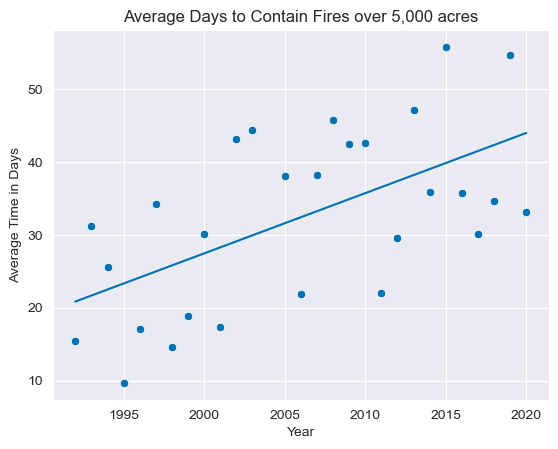

                            OLS Regression Results                            
Dep. Variable:        time_difference   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     13.49
Date:                Thu, 24 Apr 2025   Prob (F-statistic):            0.00109
Time:                        09:44:01   Log-Likelihood:                -103.51
No. Observations:                  28   AIC:                             211.0
Df Residuals:                      26   BIC:                             213.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1624.8199    451.276     -3.600      0.0

In [8]:
time_changes = firedf.copy()
time_changes["time_difference"]= (time_changes["CONT_DATE"] -  time_changes["DISCOVERY_DATE"]).dt.days
time_change = time_changes.groupby('FIRE_YEAR')["time_difference"].mean().reset_index()
sns.scatterplot(time_change, y = "time_difference",  x= "FIRE_YEAR", color="#0072B2")
X = time_change["FIRE_YEAR"]
y = time_change["time_difference"]
model = smf.ols('time_difference ~ FIRE_YEAR', data=time_change).fit()
sns.lineplot(x=time_change["FIRE_YEAR"], y=model.fittedvalues, color="#0072B2")
plt.title("Average Days to Contain Fires over 5,000 acres")
plt.xlabel("Year")
plt.ylabel("Average Time in Days")
plt.show()
print(model.summary())

# Regions of Fires

### Line Plot: Region Proportions of fires

In [9]:
states_dict = {
    "West": ["WA", "OR", "CA", "AZ", "UT", "NV", "CO", "WY", "MT", "ID", "NM", "AK"],
    "Midwest": ["ND", "SD", "NE", "KS", "MN", "MI"],
    "South": ["TX", "OK", "AK", "NC", "FL", "GA" ]
}
def region(state):
    for region, states in states_dict.items():
        if state in states:
            return region

/var/folders/y3/ph_dk0xn09n503mvdjfq9r1h0000gn/T/ipykernel_62457/1401819873.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fires_per_year = statesdf.groupby(["FIRE_YEAR", "Region"]).size().unstack()


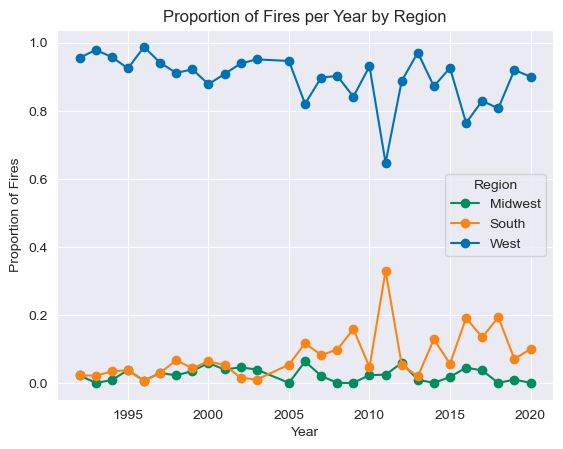

In [10]:
statesdf = firedf.copy()
statesdf["Region"] = statesdf["STATE"].apply(region)
statesdf["Region"] = statesdf["Region"].astype("category")
sns.set_style("darkgrid")
colors = ["#008c5c","#f98517", "#0072B2"]
fires_per_year = statesdf.groupby(["FIRE_YEAR", "Region"]).size().unstack()
fires_proportion = fires_per_year.div(fires_per_year.sum(axis=1), axis=0)
fires_proportion.plot(kind="line", marker="o", color=colors)
plt.xlabel("Year")
plt.ylabel("Proportion of Fires")
plt.title("Proportion of Fires per Year by Region")
plt.legend(title="Region")

### Pie Chart: Causes in 1992, 2004, 2020

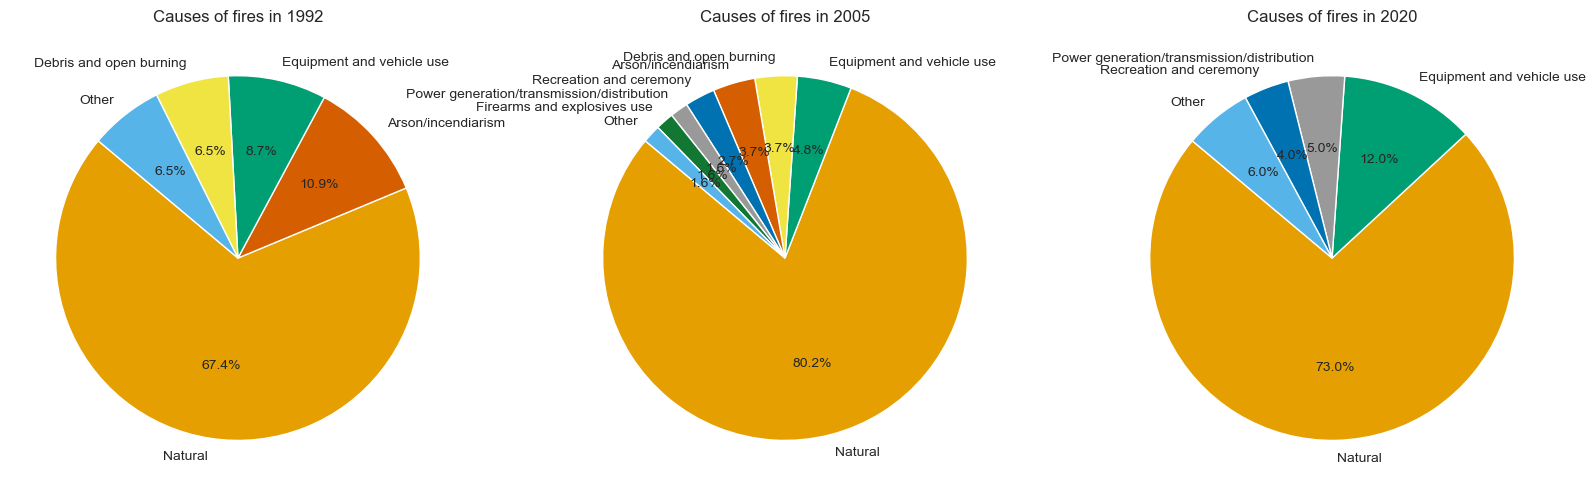

In [11]:
target_years = [1992,2005,2020]
ccolors = {
    "Natural": "#E69F00",
    "Other" : "#56B4E9",
    "Equipment and vehicle use": "#009E73",
    "Debris and open burning": "#F0E442",
    "Recreation and ceremony" : "#0072B2",
    "Arson/incendiarism":  "#D55E00",
    "Smoking":  "#CC79A7",
    "Power generation/transmission/distribution" : "#999999",
    "Firearms and explosives use" : "#117733"
}
colorssns = sns.color_palette()
df_filtered = firedf[firedf['FIRE_YEAR'].isin([1992, 2005, 2020])]
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
#USED AI TO GET THE 'OTHER' to work
for i, year in enumerate(target_years):
    cause_counts = df_filtered[df_filtered["FIRE_YEAR"] == year]["NWCG_GENERAL_CAUSE"].value_counts()
    dic= cause_counts.to_dict()
    newdic={}
    for key, group in itertools.groupby(dic, lambda k: 'Other' if (dic[k]<3) else k):
         newdic[key] = sum([dic[k] for k in list(group)])   

    labels = newdic.keys()
    sizes = newdic.values()
    colors = [ccolors[cause] for cause in labels]
    axes[i].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
    axes[i].set_title(f"Causes of fires in {year}")




# Other Visuals (Not Included in Report)

### Map: Fire Count by State

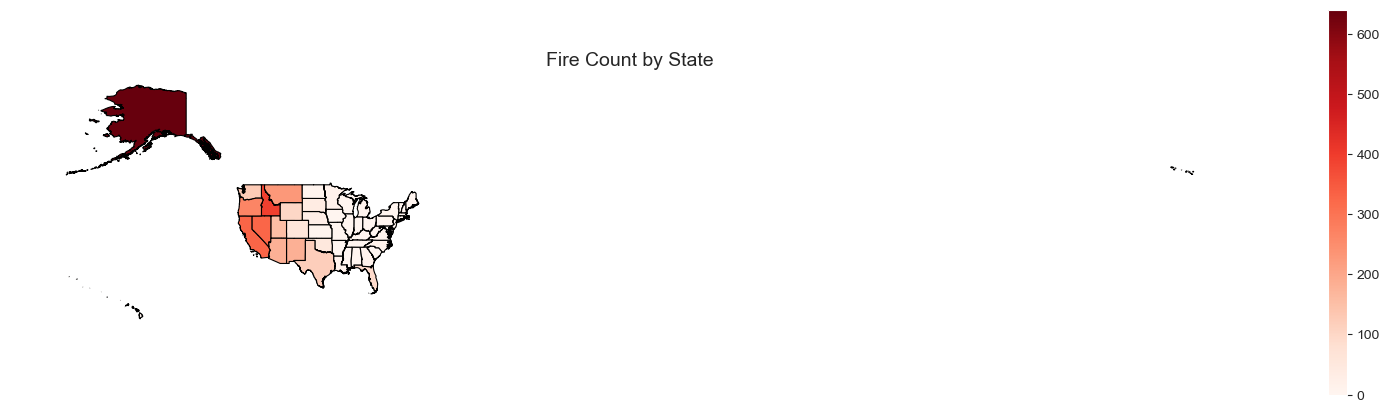

In [12]:
states_map = geopandas.read_file("/Users/sbg/Desktop/wildfires/cb_2018_us_state_500k")
state_counts = firedf.copy()
us_states_abbr = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME",
    "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA",
    "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]
filtered_states = states_map[states_map["STUSPS"].isin(us_states_abbr)]
state_counts = state_counts.groupby('STATE').size().reset_index(name='Count')
merged = filtered_states.merge(state_counts, left_on="STUSPS", right_on="STATE", how="left")
merged["Count"] = merged["Count"].fillna(0)
fig, ax = plt.subplots(1, 1, figsize=(20,5))
merged.plot(column="Count", cmap="Reds", linewidth=0.8, edgecolor="black", legend=True, ax=ax)

ax.set_title("Fire Count by State", fontsize=14)
ax.axis("off")
plt.show()


### Machine Learning Model to predict whether a fire is human or natural

In [27]:

horn = firedf.copy()
horn.drop(["DISCOVERY_DATE", "CONT_DATE", "FIRE_SIZE_CLASS", "OWNER_DESCR", "X", "Y","FIRE_NAME", "NWCG_GENERAL_CAUSE"], axis=1, inplace=True)
print(horn.info())
le = LabelEncoder()
horn["Cause"]  = le.fit_transform(horn["NWCG_CAUSE_CLASSIFICATION"] )
horn.drop("NWCG_CAUSE_CLASSIFICATION", axis=1, inplace=True)
horn = pd.get_dummies(horn)
X = horn.drop('Cause', axis=1)
y = horn["Cause"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
cause_class = RandomForestClassifier(n_estimators=200)
cause_class.fit(X_train, y_train)
y_pred = cause_class.predict(X_test)
print(cause_class.score(X_test,y_test))
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print(precision_score(y_test, y_pred))




<class 'pandas.core.frame.DataFrame'>
Index: 3386 entries, 188 to 2303564
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   FIRE_YEAR                  3386 non-null   int32  
 1   DISCOVERY_DOY              3386 non-null   int64  
 2   NWCG_CAUSE_CLASSIFICATION  3386 non-null   object 
 3   CONT_DOY                   3386 non-null   float64
 4   FIRE_SIZE                  3386 non-null   float64
 5   LATITUDE                   3386 non-null   float64
 6   LONGITUDE                  3386 non-null   float64
 7   STATE                      3386 non-null   object 
dtypes: float64(4), int32(1), int64(1), object(2)
memory usage: 224.9+ KB
None
0.8415354330708661
0.8490127758420442


### Time Difference vs Cause visualization

                            OLS Regression Results                            
Dep. Variable:        time_difference   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     344.6
Date:                Thu, 24 Apr 2025   Prob (F-statistic):           2.47e-73
Time:                        09:44:03   Log-Likelihood:                -16975.
No. Observations:                3386   AIC:                         3.395e+04
Df Residuals:                    3384   BIC:                         3.397e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -86.3426      6.489    -13.306      0.0

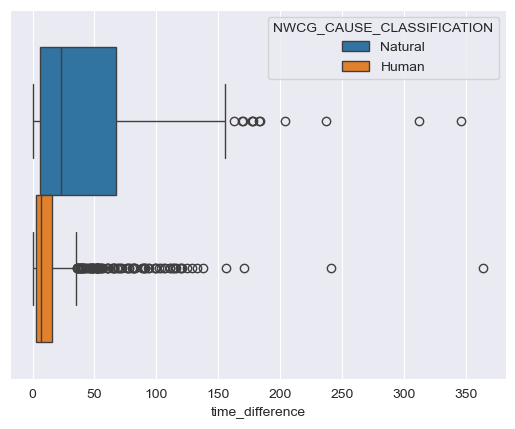

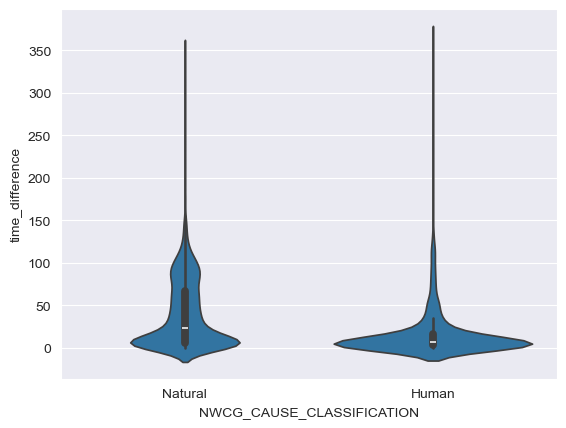

In [14]:
time_change = firedf.copy()
time_change["time_difference"]= (time_change["CONT_DATE"] -  time_change["DISCOVERY_DATE"]).dt.days
time_change["LOG"] = time_change["FIRE_SIZE"].apply(lambda x: math.log10(x))
regr = LinearRegression()
model = smf.ols('time_difference ~ LOG', data=time_change).fit()
print(model.summary())
sns.boxplot(time_change, x=(time_change["time_difference"]), hue="NWCG_CAUSE_CLASSIFICATION")
plt.show()
sns.violinplot(x="NWCG_CAUSE_CLASSIFICATION", y=time_change["time_difference"], data=time_change)
plt.show()


    